# Demo of weatherJack

`weatherJack` is a self-contained package implemented to find optimal spots on earth that have both a large global impact on the weather and are technologically favorable for the artificial addition of clouds or extraction of water. The implemented algorithm estimates the potential impact on the global weather by finding interconnected spots (connected through water transport) that are furthest apart. Let's start.

In [1]:
import weatherJack as wj

The analysis of weather data requires information on *relative humidity*, *fraction of cloud coverage*, *wind direction* and *-magnitude*. For this, IBM's PAIRS API is used. To access this data, first provide an API key:

In [2]:
API_KEY = "0" # provide your key here, "0" will work only from cache

The connection to PAIRS in then conveniently managed by `weatherJack` through the `ibmPAIRSWrapper`:

In [3]:
pairs = wj.ibmPAIRSWrapper(api_key=API_KEY)

As a core concept, `weatherJack` is kept highly customizable. The user can define a broad range of parameters that are hold in the `parameters` class. At the moment, the following user parameters are `'CRIT_CC', 'CRIT_TD_FAC', 'ID_CLOUD_COV', 'ID_REL_HUMID', 'ID_WIND_EAST', 'ID_WIND_NORTH', 'LA_N', 'LA_S', 'LO_E', 'LO_W', 'MONTH_END', 'MONTH_START', 'PRESSURE_LEVEL', 'YEARS'`. You can have a look at them and modify them to your needs (to choose data layers of your choice or change, e.g., the area you are most interested in) but for now, let's use the well-chosen default ones.

In [4]:
par = wj.parameters()

To avoid unnecessary server request (which are slow), the `weatherData` class takes care of managing the weather data. It also loads data to cache, so theoretically, this package can be used completely without internet connection. To get a little more information, we enable verbose output.

In [5]:
wdata = wj.weatherData(pairs,verbose=True)

To test the connection, we download the relative humidity (layer id hold in par.ID_REL_HUMID) for a pressure level of 500 hPa (contained in `PRESSURE_LEVEL`) of the year 2017, averaged from the beginning of January until beginning of March averaged:

In [6]:
data = wdata.get_data(par.ID_REL_HUMID, par.PRESSURE_LEVEL, 2017, 1, 3)

Read data from cache...


What is returned is a dictionary, with keys `'data'` and `'metadata'` as also known from the PAIRS API. Let's have a look at the global humidity distribution:

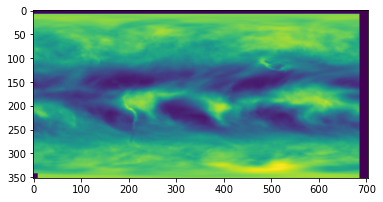

In [7]:
import matplotlib.pyplot as plt
plt.imshow(data["data"])
plt.show()

Nice, but we can do also more averaging that is beyond a standard PAIRS request. For example, we can average the data for these months *over multiple years*:

Read data from cache...
Year averaging...
1/3
Read data from cache...
2/3
Read data from cache...
3/3


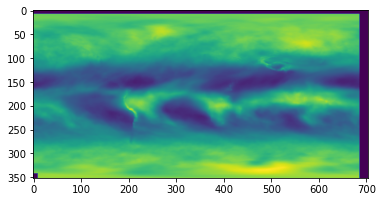

In [8]:
avg_data = wdata.year_average_data(par.ID_REL_HUMID, par.PRESSURE_LEVEL, [2017,2018,2016], 1, 3)
plt.imshow(avg_data)
plt.show()

These features are quite handy but eventually we are interested to find best spots for weather manipulation. All the required logic for that is provided by the `analyzer` class which takes the weather data and our user parameters as an argument. It will also automatically request all the data that is needed for the analysis:

In [9]:
analyzer = wj.analyzer(wdata, par)

Read data from cache...
Read data from cache...
Year averaging...
1/3
Read data from cache...
2/3
Read data from cache...
3/3
Read data from cache...
Year averaging...
1/3
Read data from cache...
2/3
Read data from cache...
3/3
Read data from cache...
Year averaging...
1/3
Read data from cache...
2/3
Read data from cache...
3/3
Read data from cache...
Year averaging...
1/3
Read data from cache...
2/3
Read data from cache...
3/3


Within the user-specified area of interest (`LA_N, LA_S, LO_W, LO_E` of `par`), a collection of user grids are calculated that are required in the finding for the best spots. Note, that the separation of global grids and user grids makes this package also suitable to analyze more local scales, e.g. search for optimal sites for power plants that produce a lot of steam next to cities.

In [10]:
rh, cc, td = analyzer.compute_user_grids()

From these user grids, the scores that indicate optimal spots are computed. Here, the S1 score indications best spots for adding clouds and the counterpart S2 score for extracting water from the atmosphere.

In [11]:
s1 = analyzer.compute_score1(rh, cc, td)
s2 = analyzer.compute_score2(rh, cc, td)

As a side note, it is important to realize that the expected impact can be obtained without knowing about technical requirements for the realization. The score however takes also the difficulty for practical realization into account. These details are reflected in the user parameters `CRIT_CC` and `CRIT_TD` and are subject of the subsequent engineering stage.

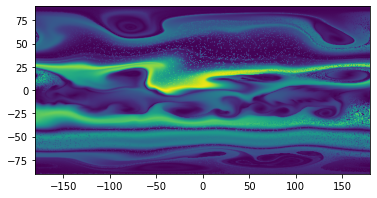

In [12]:
plt.imshow(s1, extent=[par.LO_W, par.LO_E, par.LA_S, par.LA_N])
plt.show()

The score data from above can then be directly used from scientists to conduct weather simulations. For post-processing the maxima, the convenience function `find_maxs(data, n_max=5, excl_radius=40)` is implemented in the `analyzer` class. Finally, let's use it to find 5 spots for cloud creation that are expected to be well suitable while also having a great effect on global weather:

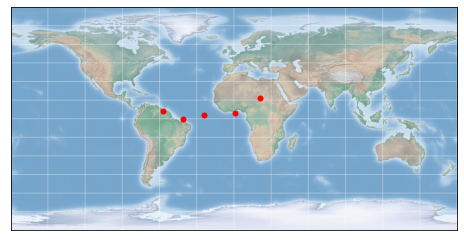

In [13]:
s1_la_maxs, s1_lo_maxs = analyzer.find_maxs(s1)

import numpy as np
import os
os.environ["PROJ_LIB"] = "/opt/conda/share/proj/" # fixing IBM's jupyter notebook problem
from mpl_toolkits.basemap import Basemap

from itertools import chain
def draw_map(m, scale=0.2):
    """Thanks to https://jakevdp.github.io/PythonDataScienceHandbook/04.13-geographic-data-with-basemap.html"""
    # draw a shaded-relief image
    m.shadedrelief(scale=scale)
    
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

fig = plt.figure(figsize=(8,6), edgecolor="w")
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=par.LA_S, urcrnrlat=par.LA_N,
            llcrnrlon=par.LO_W, urcrnrlon=par.LO_E)
draw_map(m)

x1_map, y1_map = m(s1_lo_maxs, s1_la_maxs)
plt.plot(x1_map, y1_map, "ro", markersize=5)
plt.show()